## Проведение анализа конкурентов строительной фирмы *\"Атомстройкомплекс\"*. 

Фирма *"Атомстройкомплекс"* строит объекты в Свердловской области, поэтому возьмём данные из открытых источников по теме строительных фирм, строящих объекты в Свердловской области.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd 
import requests 
import re 
from urllib.request import urlopen, urlretrieve 
from bs4 import BeautifulSoup 

### соберём данные о застройщиках с сайта sverdlovsk.move.ru

In [2]:
with urlopen('https://sverdlovsk.move.ru/companies/developers/?limit=100') as resp: 
    html = resp.read().decode('UTF-8') # считываем содержимое 

In [3]:
regex = '<a class="items-list__data__title" href="/companies/.*>(.*?)</a>' 
name_company = re.findall(regex, html) 
for index in range(len(name_company)): 
    name_company[index] = name_company[index].strip() 
print(name_company) 

['ПИК', 'Группа ЛСР (LSR)', 'Брусника', 'Страна Девелопмент', 'АО «ЮИТ Санкт-Петербург»', 'ГК «Кортрос»', 'АТОМСТРОЙКОМПЛЕКС', 'КомСтрин', 'АО «ЛСР. Недвижимость-Урал»', 'ЗАО «Желдорипотека»', 'ГК «Астра»', 'Villa66', 'Первостроитель', 'ООО «АЛЬФА-ГРУПП ЦЕНТР НЕДВИЖИМОСТИ»', 'TEN', 'СТРОЙТЭК', 'ООО «Синара-Девелопмент»', '7 прудов', 'УГМК-Холдинг', 'Корпорация «Маяк»', 'ГК «АктивСтройСервис»', 'Холдинг «Форум-групп»', 'Avento Land Development Company', 'ГК «Скон»', 'ЗАО «Среднеуральская строительная компания (ССК)»', 'УК «AVS Девелопмент»', 'ГК «Атлас Девелопмент»', 'PRINZIP', 'ГК «Ривьера Инвест Екатеринбург»', 'ООО «Проспект Девелопмент»', 'ГК «Резиденция»', 'Формула Строительства', 'ООО «Эфес»', 'ГК «PREMIER»', 'ООО «Деметра»', 'Acons Group', 'ООО «Фортис»', 'ООО «Возрождение Екатеринбурга»', 'Real Estate Development', 'ARK Development', 'Элит-ГРУПП', 'АО «Земельный ресурс»', 'ЖСК «Новая Жизнь – Победа!»', 'ООО «Золотая горка»', 'ООО СК «СУ-22»', 'ООО «Стройкор»', 'ООО «СК Союз»', '

In [4]:
# Всего строительных фирм по данным сайта
len(name_company) 

63

In [5]:
# Возьмём ссылки на типы недвижимости
regex1 = '<a href="//sverdlovsk.move.ru(.*?)" class="">(.*?)</a>' 
link = re.findall(regex1, html) 
vid_link = link[:4] 
print(vid_link) 

[('/novostroyki/', 'Новостройки'), ('/kottedzhnye_poselki/', 'Коттеджные поселки'), ('/business_centers/', 'Бизнес-центры'), ('/kommercheskaya_nedvijimost/', 'Коммерческая')]


In [153]:
# Напишем 2 переменные
URL = 'https://sverdlovsk.move.ru/' + vid_link[0][0] 
HEADERS = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:71.0) Gecko/20100101 Firefox/71.0', 'accept': '*/*'} 

In [228]:
# Напишем функцию для принятия двух аргументов
def get_html(url, params=None): 
    r = requests.get(url, headers=HEADERS, params=params) 
    return r 

# Функция для получения текста между тегами не включая внутренний текст
def getText(parent):
    return ''.join(parent.find_all(text=True, recursive=False)).strip() 

# Напишем функцию для получения объекта
def get_content(html): 
    soup = BeautifulSoup(html, 'html.parser') 
    items = soup.find_all('div', class_='similar-novostroyki_row clearfix')
    houses = [] 
    for item in items: 
        # добавим проверку на наличие данных объекта по тегам
        if item.find('span', class_='row-info_label nb-blue'): 
            year = item.find('span', class_='row-info_label nb-blue').get_text(strip=True) 
        if item.find('span', class_='row-info_label nb-green'): 
            year = item.find('span', class_='row-info_label nb-green').get_text(strip=True) 
        if item.find('span', class_='row-info_label nb-gray'): 
            year = item.find('span', class_='row-info_label nb-gray').get_text(strip=True) 
        if item.find('div', class_='row-info_price'): 
            rub = getText(item.find('div', class_='row-info_price')).replace(' ','').split('—') 
            if [x for x in rub if x.isdigit()]: 
                rub = [int(x) for x in rub] 
            else: 
                rub = 'Продано' 
        if item.find('div', class_='row-info_developer').get_text('|', strip=True): 
            if len(item.find('div', class_='row-info_developer').get_text('|', strip=True).split('|')) > 1: 
                company = item.find('div', class_='row-info_developer').get_text('|', strip=True).split('|')[1] 
            else: 
                comp = item.find('div', class_='row-info_developer').get_text(strip=True) 
                company = comp[comp.find('йщика ')+6:comp.find(',')] 
        houses.append({
            'Год_сдачи': year, 
            'Название_квартала': getText(item.find('a', class_='row-info_name__name')), 
            'Цена': rub, 
            'Компания': company, 
            'Адрес': item.find('div', class_='geo-block__geo-info').get_text(' ', strip=True).replace('\n',' '), 
            'Класс_недвижимости': item.find('span', class_='row-info_tags-tag').get_text(strip=True), 
            'Площадь': item.find('span', class_='row-info_tags-tag').find_next('span').get_text(strip=True), 
            'Конструкция': item.find('span', class_='row-info_tags-tag').find_next('span')\
            .find_next('span').get_text(strip=True) 
                     }) 
    return houses 

# код '200', значит это, что мы успешно подключены и все в полном порядке 
def parse(URL): 
    html = get_html(URL) 
    if html.status_code == 200: 
        return get_content(html.text) 
    else: 
        print('Error site') 

In [230]:
# Соберем данные с сайта по новостройкам в один DataFrame 
from tqdm import notebook 

# Количество страниц на сайте предварительно посмотрели - их 8
table = [] 
for i in notebook.tqdm(range(1, 9)): 
    url_new = URL + f'?page={i}&limit=30' 
    s = parse(url_new) 
    table.extend(s) 
table_new_house = pd.DataFrame(table) 

# Выведем на экран первые 5 строк
table_new_house.head() 

,Год_сдачи,Название_квартала,Цена,Компания,Адрес,Класс_недвижимости,Площадь,Конструкция
0,БУДЕТ СДАН В 2026,"ЖК «Академический», г. Екатеринбург","[2495810, 7096500]",ГК «Кортрос»,г. Екатеринбург ул. Павла Шаманова 13,Комфорт класс,от 23 до 165 м2,Монолитный
1,БУДЕТ СДАН В 2024,"ЖК «Новый ВИЗ», г. Екатеринбкрг","[3066310, 7441680]",ГК «Астра»,г. Екатеринбург ул Металлургов,Комфорт класс,от 28 до 76 м2,Монолитный
2,БУДЕТ СДАН В 2024,"ЖК «Екатерининский парк», г. Екатеринбург","[4330000, 21500000]",TEN,г. Екатеринбург ул Азина,Комфорт класс,от 42 до 230 м2,Монолитный
3,БУДЕТ СДАН В 2024,"Жилой квартал FORUM CITY («Форум Сити»), г. Ек...",[14857900],Холдинг «Форум-групп»,"г. Екатеринбург ул Шейнкмана 57А УИБ, 119 м",Бизнес класс,от 52 до 162 м2,Монолитный
4,БУДЕТ СДАН В 2024,"ЖК «Александровский сад», г. Екатеринбург","[9344120, 17560500]",Холдинг «Форум-групп»,"г. Екатеринбург ул Декабристов Телебашня, 237 м",Бизнес класс,от 54 до 200 м2,Монолитный


In [231]:
# Посмотрим на заполненность столбцов
table_new_house.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Год_сдачи           240 non-null    object
 1   Название_квартала   240 non-null    object
 2   Цена                240 non-null    object
 3   Компания            240 non-null    object
 4   Адрес               240 non-null    object
 5   Класс_недвижимости  240 non-null    object
 6   Площадь             240 non-null    object
 7   Конструкция         240 non-null    object
dtypes: object(8)
memory usage: 15.1+ KB


In [233]:
# Посмотрим на количество компаний, представленных на сайте
table_new_house['Компания'].nunique() 

54

In [239]:
# Проверим каких компаний нет в общем списке застройщиков 
k = 0 
for company in list(table_new_house['Компания'].unique()): 
    if company not in name_company: 
        k += 1 
        print(company) 
    else: 
        k += 0 
print(f'Всего компаний, не входящих в общий список застройщиков: {k}')

АО «ЮИТ Уралстрой»
Всего компаний, не входящих в общий список застройщиков: 1


In [246]:
# Добавим столбцы с максимальной и минимальной стоимостью новостроек
table_new_house.loc[:, 'Мин_цена'] = table_new_house['Цена'].apply(lambda x: x[0] if type(x[0])==int else 0) 
table_new_house.loc[:, 'Макс_цена'] = table_new_house['Цена'].apply(lambda x: x[1] if len(x) > 1 and type(x[1])==int else 0) 

# Посмотрим на результат
table_new_house.head() 

,Год_сдачи,Название_квартала,Цена,Компания,Адрес,Класс_недвижимости,Площадь,Конструкция,Мин_цена,Макс_цена,Мин_площадь,Макс_площадь
0,БУДЕТ СДАН В 2026,"ЖК «Академический», г. Екатеринбург","[2495810, 7096500]",ГК «Кортрос»,г. Екатеринбург ул. Павла Шаманова 13,Комфорт класс,от 23 до 165 м2,Монолитный,2495810,7096500,23,165
1,БУДЕТ СДАН В 2024,"ЖК «Новый ВИЗ», г. Екатеринбкрг","[3066310, 7441680]",ГК «Астра»,г. Екатеринбург ул Металлургов,Комфорт класс,от 28 до 76 м2,Монолитный,3066310,7441680,28,76
2,БУДЕТ СДАН В 2024,"ЖК «Екатерининский парк», г. Екатеринбург","[4330000, 21500000]",TEN,г. Екатеринбург ул Азина,Комфорт класс,от 42 до 230 м2,Монолитный,4330000,21500000,42,230
3,БУДЕТ СДАН В 2024,"Жилой квартал FORUM CITY («Форум Сити»), г. Ек...",[14857900],Холдинг «Форум-групп»,"г. Екатеринбург ул Шейнкмана 57А УИБ, 119 м",Бизнес класс,от 52 до 162 м2,Монолитный,14857900,0,52,162
4,БУДЕТ СДАН В 2024,"ЖК «Александровский сад», г. Екатеринбург","[9344120, 17560500]",Холдинг «Форум-групп»,"г. Екатеринбург ул Декабристов Телебашня, 237 м",Бизнес класс,от 54 до 200 м2,Монолитный,9344120,17560500,54,200


In [247]:
# Добавим столбцы с максимальной и минимальной площадью
table_new_house.loc[:, 'Мин_площадь'] = table_new_house['Площадь'].apply(lambda x: int(x.split()[1])) 
table_new_house.loc[:, 'Макс_площадь'] = table_new_house['Площадь'].apply(lambda x: int(x.split()[3])) 

# Посмотрим на результат
table_new_house.head() 

,Год_сдачи,Название_квартала,Цена,Компания,Адрес,Класс_недвижимости,Площадь,Конструкция,Мин_цена,Макс_цена,Мин_площадь,Макс_площадь
0,БУДЕТ СДАН В 2026,"ЖК «Академический», г. Екатеринбург","[2495810, 7096500]",ГК «Кортрос»,г. Екатеринбург ул. Павла Шаманова 13,Комфорт класс,от 23 до 165 м2,Монолитный,2495810,7096500,23,165
1,БУДЕТ СДАН В 2024,"ЖК «Новый ВИЗ», г. Екатеринбкрг","[3066310, 7441680]",ГК «Астра»,г. Екатеринбург ул Металлургов,Комфорт класс,от 28 до 76 м2,Монолитный,3066310,7441680,28,76
2,БУДЕТ СДАН В 2024,"ЖК «Екатерининский парк», г. Екатеринбург","[4330000, 21500000]",TEN,г. Екатеринбург ул Азина,Комфорт класс,от 42 до 230 м2,Монолитный,4330000,21500000,42,230
3,БУДЕТ СДАН В 2024,"Жилой квартал FORUM CITY («Форум Сити»), г. Ек...",[14857900],Холдинг «Форум-групп»,"г. Екатеринбург ул Шейнкмана 57А УИБ, 119 м",Бизнес класс,от 52 до 162 м2,Монолитный,14857900,0,52,162
4,БУДЕТ СДАН В 2024,"ЖК «Александровский сад», г. Екатеринбург","[9344120, 17560500]",Холдинг «Форум-групп»,"г. Екатеринбург ул Декабристов Телебашня, 237 м",Бизнес класс,от 54 до 200 м2,Монолитный,9344120,17560500,54,200


<AxesSubplot:ylabel='Компания'>

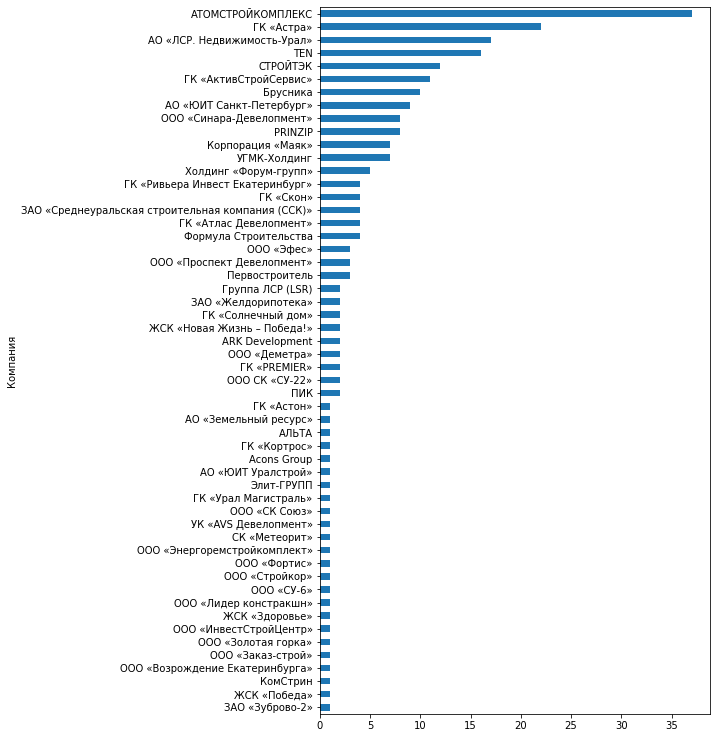

In [256]:
# Построим столбчатую диаграмму по количеству объектов у компаний
table_new_house.groupby('Компания')['Год_сдачи'].count().sort_values(ascending=True).plot(kind='barh', figsize=(7, 13)) 

In [258]:
# Добавим столбец со средней ценой и сохраним нашу таблицу в формате csv
table_new_house.loc[:, 'Средняя_цена'] = table_new_house.apply(lambda x: 
                                                               (x['Мин_цена']+x['Макс_цена'])/2 
                                                               if x['Макс_цена']!=0 
                                                               else x['Мин_цена'],
                                                              axis=1) 
table_new_house.head() 

,Год_сдачи,Название_квартала,Цена,Компания,Адрес,Класс_недвижимости,Площадь,Конструкция,Мин_цена,Макс_цена,Мин_площадь,Макс_площадь,Средняя_цена
0,БУДЕТ СДАН В 2026,"ЖК «Академический», г. Екатеринбург","[2495810, 7096500]",ГК «Кортрос»,г. Екатеринбург ул. Павла Шаманова 13,Комфорт класс,от 23 до 165 м2,Монолитный,2495810,7096500,23,165,4796155.0
1,БУДЕТ СДАН В 2024,"ЖК «Новый ВИЗ», г. Екатеринбкрг","[3066310, 7441680]",ГК «Астра»,г. Екатеринбург ул Металлургов,Комфорт класс,от 28 до 76 м2,Монолитный,3066310,7441680,28,76,5253995.0
2,БУДЕТ СДАН В 2024,"ЖК «Екатерининский парк», г. Екатеринбург","[4330000, 21500000]",TEN,г. Екатеринбург ул Азина,Комфорт класс,от 42 до 230 м2,Монолитный,4330000,21500000,42,230,12915000.0
3,БУДЕТ СДАН В 2024,"Жилой квартал FORUM CITY («Форум Сити»), г. Ек...",[14857900],Холдинг «Форум-групп»,"г. Екатеринбург ул Шейнкмана 57А УИБ, 119 м",Бизнес класс,от 52 до 162 м2,Монолитный,14857900,0,52,162,14857900.0
4,БУДЕТ СДАН В 2024,"ЖК «Александровский сад», г. Екатеринбург","[9344120, 17560500]",Холдинг «Форум-групп»,"г. Екатеринбург ул Декабристов Телебашня, 237 м",Бизнес класс,от 54 до 200 м2,Монолитный,9344120,17560500,54,200,13452310.0


In [259]:
table_new_house.to_csv(r'D:\Обучение\Analysis_Ekb_stroy\novostroyki_ekb.csv') 

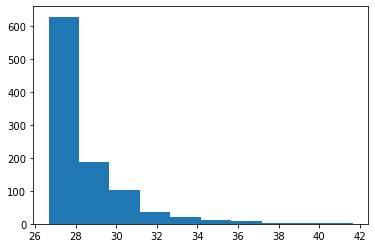

In [489]:
import random
import matplotlib.pyplot as plt

y = []
for i in range(1000):

    x = []
    for i in range(100):
        x.append(random.randint(0, 1))

    y.append((x.count(0) - 30)**2 / 30 + (x.count(1) - 30)**2 / 30)
plt.hist(y)
plt.show()

In [490]:
# Какая доля наблюдений лежит в диапазоне от 2 до 4 у распределения хи-квадрат с двумя степенями свободы?
from scipy import stats 

a=stats.chi2.cdf(2 , 2)
b=stats.chi2.cdf(4 , 2)
c=b-a
print(a)
print(b) 
print(c) 

0.6321205588285577
0.8646647167633873
0.23254415793482963


In [492]:
stats.chisquare([10, 10, 10, 5, 10, 15]) 

Power_divergenceResult(statistic=5.0, pvalue=0.4158801869955079)

In [426]:
hostid_url_opt.rename(columns={0:'id_host', 1:'URL_doc'}, inplace=True) 
hostid_url_opt.head() 

,id_host,URL_doc
0,1,http://09spravki.ru/requisites.php
1,10,http://3pu.info/seo-tools/domains
2,1006,http://www.priroda.su/item/820
3,1007,http://www.prisnilos.su/znaki_zodiaka/strelets...
4,1009,http://www.prohotel.ru/hotel-108042/0/


In [427]:
URL_doc = qid_url_rating_opt.merge(hostid_url_opt, on='URL_doc', how='left') 
URL_doc.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 803 entries, 0 to 802
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_request  803 non-null    int64  
 1   URL_doc     803 non-null    object 
 2   Rel         803 non-null    float64
 3   id_host     803 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 31.4+ KB


In [428]:
total1 = qid_query_opt.merge(URL_doc, on='id_request', how='left') 
total1.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 803 entries, 0 to 802
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_request  803 non-null    int64  
 1   t_request   803 non-null    object 
 2   URL_doc     803 non-null    object 
 3   Rel         803 non-null    float64
 4   id_host     803 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 37.6+ KB


In [429]:
total1.head() 

,id_request,t_request,URL_doc,Rel,id_host
0,402111,работа фотографом в австралии,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
1,402111,работа фотографом в австралии,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
2,402111,работа фотографом в австралии,http://802351.info/5964-v-avstralii.html,0.00,13
3,402111,работа фотографом в австралии,http://auscommunity.com/blog/jobs/,0.00,53
4,402111,работа фотографом в австралии,http://auscommunity.com/tag/%D1%84%D0%BE%D1%82...,0.00,53


In [430]:
total = total1.sort_values('Rel', ascending=False).groupby('id_host', as_index=False)[['t_request','URL_doc', 'Rel']]\
.agg({'t_request':'first','URL_doc':'first','Rel':'max'}).reset_index() 

In [415]:
import numpy as np 

def pLook(x): 
    if x.pLook.shift(1)!=1: 
        return x.pLook.shift(1)*(1 - x.Rel.shift(1))*(1 - 0.15) 

In [431]:
total = total.sort_values('Rel', ascending=False).reset_index() 
total.loc[0, 'pLook'] = 1 
total.iloc[1:, 6] = 0 
#total.loc[:, 'pLook'] = total.apply(pLook, axis=1) 

In [433]:
total.head(20) 

,level_0,index,id_host,t_request,URL_doc,Rel,pLook
0,413,413,837,"Гостиница Polaris, Сургут",http://www.hotelpolaris.ru/,0.61,1.0
1,288,288,594,"КВН ""Утомленные солнцем""",http://us-kvn.narod.ru/,0.61,0.0
2,508,508,1035,бесплатный просмотр камеди клаб,http://www.rucomedy.com/,0.61,0.0
3,575,575,1180,avz как пользоваться,http://z-oleg.com/secur/avz_doc/,0.61,0.0
4,540,540,1101,туту,http://www.tutu.ru/,0.61,0.0
5,530,530,1090,производительность видеокарт,http://www.thg.ru/graphic/,0.41,0.0
6,563,563,1155,бесплатный просмотр камеди клаб,http://www.youtube.com/watch?v=LfR1rYXKaQM,0.41,0.0
7,450,450,906,поделка букет цветов,http://www.mam2mam.ru/articles/favorites/artic...,0.41,0.0
8,541,541,1103,что такое былина,http://www.tvoyhram.ru/slavrelig/slavrelig38.html,0.41,0.0
9,273,273,560,той терьер,http://toy-terrier.info/forum/,0.41,0.0
